In [1]:
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import xarray as xr
import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import cmoocean as cmo
import warnings
from wim_dateTime import createListDateTime
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
import os
import glob


def convertEgg2Num_FSD(fsd_egg):
    
    #Remove unknown ice free, unknown, and land
    sic_num=fsd_egg.where(fsd_egg<99).values
    sic_num[sic_num==22]=1.65
    sic_num[sic_num==1]=1
    sic_num[sic_num==2]=10
    sic_num[sic_num==3]=60
    sic_num[sic_num==4]=300
    sic_num[sic_num==5]=1250
    sic_num[sic_num==6]=6000
    sic_num[sic_num==7]=15000
    sic_num[sic_num==8]=np.nan
    sic_num[sic_num==9]=0
    sic_num[sic_num==10]=0
    sic_num[sic_num==21]=15000
    return sic_num.astype(float)


def convertEgg2Num_SIC(sic_egg):
    
    #Remove unknown ice free, unknown, and land
    sic_num=sic_egg.where(sic_egg<99).values
    sic_num[sic_num==92]=10
    sic_num[sic_num==91]=9.5
    sic_num[sic_num==90]=9
    sic_num[sic_num==89]=8.5
    sic_num[sic_num==81]=9
    sic_num[sic_num==80]=8
    sic_num[sic_num==79]=8
    sic_num[sic_num==78]=7.5
    sic_num[sic_num==70]=7
    sic_num[sic_num==68]=7
    sic_num[sic_num==67]=6.5
    sic_num[sic_num==57]=6
    sic_num[sic_num==56]=5.5
    sic_num[sic_num==46]=5
    sic_num[sic_num==45]=4.5
    sic_num[sic_num==35]=4
    sic_num[sic_num==34]=3.5
    sic_num[sic_num==24]=3
    sic_num[sic_num==23]=2.5
    sic_num[sic_num==13]=2
    sic_num[sic_num==12]=1.5
    sic_num[sic_num==60]=6
    sic_num[sic_num==50]=5
    sic_num[sic_num==40]=4
    sic_num[sic_num==30]=3
    sic_num[sic_num==20]=2
    sic_num[sic_num==10]=1
    sic_num[sic_num==98]=0
    sic_num[sic_num==2]=0.1
    sic_num[sic_num==1]=0.1
    sic_num[sic_num<=0]=0

    return sic_num.astype(float)/10


def convertEgg2Num_ITD(sic_egg):
    
    #Remove unknown ice free, unknown, and land
    sic_num=sic_egg.where(sic_egg<99).values
    sic_num[sic_num==80]=0
    sic_num[sic_num==90]=np.nan
    sic_num[sic_num==92]=np.nan
    sic_num[sic_num==98]=0
    sic_num[sic_num==81]=5
    sic_num[sic_num==82]=5
    sic_num[sic_num==83]=20
    sic_num[sic_num==84]=12.5
    sic_num[sic_num==85]=22.5
    sic_num[sic_num==87]=50
    sic_num[sic_num==88]=40
    sic_num[sic_num==89]=60
    sic_num[sic_num==91]=95
    sic_num[sic_num==93]=200
    sic_num[sic_num==94]=150
    sic_num[sic_num==95]=300
    sic_num[sic_num==96]=250
    sic_num[sic_num==97]=350
    
    return sic_num.astype(float)

def readCryoSatFiles(list_file_N7, list_file_C2):
    #Nimbus-7000 stuff
    listN7=[]
    listC2=[]
    stdN7=[]
    stdC2=[]
    indexF=0
    for file_N7 in list_file_N7:
        fileC2=list_file_C2[indexF]
        dx_obs_fsd=np.squeeze(xr.open_dataset(fileC2))
        dx_obs=np.squeeze(xr.open_dataset(file_N7))
        tempN7=np.squeeze(dx_obs.F17_ICECON) 
        listN7.append(tempN7)
        tempC2=np.squeeze(dx_obs_fsd.fsdrad)*2
        listC2.append(tempC2)
        
#         mask_1 = np.logical_or(tempN7.values > 1, tempN7.values < 0.15)
#         mask_3 = np.logical_or(tempN7.values > 1, tempN7.values > 0.8)
#         mask_4 = np.logical_or(tempN7.values > 1, tempN7.values > 0.9)
#         mask_2 = np.logical_or(tempC2>300, tempC2==300)   
    
#         area_fsd_y = ma.masked_array(dx_NSIDC.values, mask=mask_1+mask_2+mask_lab+mask_lab2)
#         area_aice_y = ma.masked_array(dx_NSIDC.values, mask=mask_1+mask_3+mask_lab+mask_lab2)
        
#         stdN7.append(np.sum(np.sum(area_aice_y, axis=0))/1e12)
#         stdC2.append(np.sum(np.sum(area_fsd_y, axis=0))/1e12)
        
#         indexF=indexF+1

#     std_aice=np.nanstd(np.array(stdN7))
#     std_fsd=np.nanstd(np.array(stdC2))
# #     MIZ_aice_obs=np.nanmean(np.array(stdN7))
# #     MIZ_fsd_obs=np.nanmean(np.array(stdC2))
    avg_aice_obs=np.nanmean(np.stack(listN7),axis=0)
    avg_fsd_obs=np.nanmean(np.stack(listC2),axis=0)
    return [avg_aice_obs, avg_fsd_obs]

def readIceChartFiles(list_files):
    
    grid_IC='/storage/bward/obs/iceChart/depot.cmc.ec.gc.ca/upload/mrb/caya/area.nc'
    dx_IC=xr.open_dataset(grid_IC)
    dx_IC=dx_IC.AREA
    lat_IC=dx_IC.lat
    lon_IC=dx_IC.lon
    mask_labIC=np.logical_or(lon_IC<=-65, lon_IC>=-43)
    mask_lab2IC=np.logical_or(lat_IC<=45, lat_IC>=72)
    
    listFA=[]
    listFB=[]
    listFC=[]

    listSA=[]
    listSB=[]
    listSC=[]

    listCA=[]
    listCB=[]
    listCC=[]
    listCT=[]

    for file_IC in list_files:
#         print(file_IC)
        ds_temp=xr.open_dataset(file_IC)

        temp_FA=convertEgg2Num_FSD(np.squeeze(ds_temp.FA))
        temp_FB=convertEgg2Num_FSD(np.squeeze(ds_temp.FB))
        temp_FC=convertEgg2Num_FSD(np.squeeze(ds_temp.FC))
        temp_SA=convertEgg2Num_ITD(np.squeeze(ds_temp.SA))
        temp_SB=convertEgg2Num_ITD(np.squeeze(ds_temp.SB))
        temp_SC=convertEgg2Num_ITD(np.squeeze(ds_temp.SC))
        temp_CA=convertEgg2Num_SIC(np.squeeze(ds_temp.CA))
        temp_CB=convertEgg2Num_SIC(np.squeeze(ds_temp.CB))
        temp_CC=convertEgg2Num_SIC(np.squeeze(ds_temp.CC))
        temp_CT=convertEgg2Num_SIC(np.squeeze(ds_temp.CT))

        listFA.append(temp_FA)
        listFB.append(temp_FB)
        listFC.append(temp_FC)
        listSA.append(temp_SA)
        listSB.append(temp_SB)
        listSC.append(temp_SC)
        listCA.append(temp_CA)
        listCB.append(temp_CB)
        listCC.append(temp_CC)
        listCT.append(temp_CT)
           
    FSDA=np.nanmean(np.stack(listFA),axis=0)
    FSDB=np.nanmean(np.stack(listFB),axis=0)
    FSDC=np.nanmean(np.stack(listFC),axis=0)

    ITDA=np.nanmean(np.stack(listSA),axis=0)
    ITDB=np.nanmean(np.stack(listSB),axis=0)
    ITDC=np.nanmean(np.stack(listSC),axis=0)

    SICA=np.nanmean(np.stack(listCA),axis=0)
    SICB=np.nanmean(np.stack(listCB),axis=0)
    SICC=np.nanmean(np.stack(listCC),axis=0)
    SICT=np.nanmean(np.stack(listCT),axis=0)

    SIC=SICA+SICB+SICC
    SIC[SIC<=0]=np.nan

    SICT[SICT<=0.15]=np.nan

    FSD=(SICA/SIC)*FSDA+(SICB/SIC)*FSDB+(SICC/SIC)*FSDC
    
    return [SICT, FSD]

def computeMIZ_IC(temp_CT, temp_FSD):
    
    grid_IC='/storage/bward/obs/iceChart/depot.cmc.ec.gc.ca/upload/mrb/caya/area.nc'
    dx_IC=xr.open_dataset(grid_IC)
    dx_IC=dx_IC.AREA
    lat_IC=dx_IC.lat
    lon_IC=dx_IC.lon
    mask_labIC=np.logical_or(lon_IC<=-65, lon_IC>=-43)
    mask_lab2IC=np.logical_or(lat_IC<=45, lat_IC>=72)
    
    mask_IC1 = np.logical_or(np.isnan(temp_CT), temp_CT<0.15)
    mask_IC2 = np.logical_or(temp_FSD<0, temp_FSD>300)
    mask_IC3 = np.logical_or(temp_CT>1, temp_CT>0.8)
    mask_IC4 = np.logical_or(temp_CT>1, temp_CT>0.9)
#         mask_IC5 = np.logical_or(temp_CT<0, FSD<-10)

    area_fsd_y = ma.masked_array(dx_IC.values, mask=mask_IC1+mask_IC2+mask_IC3+mask_IC4)
    area_aice_y = ma.masked_array(dx_IC.values, mask=mask_IC1+mask_IC3)
    
    cMIZ=np.sum(np.sum(area_aice_y, axis=0))/1e6
    dMIZ=np.sum(np.sum(area_fsd_y, axis=0))/1e6
    
    return [cMIZ, dMIZ]

def computeMIZ_C2(tempN7, tempC2):
    
    grid_NSIDC='/storage/bward/obs/nsidc/NSIDC0771_CellArea_PS_N25km_v1.0.nc'
    dx_NSIDC=xr.open_dataset(grid_NSIDC)
    dx_NSIDC=dx_NSIDC.cell_area
    coord_obs="/storage/bward/obs/nsidc/NSIDC0771_LatLon_PS_N25km_v1.0.nc"
    dx_coord_obs=xr.open_dataset(coord_obs)
    lat_obs=dx_coord_obs.latitude
    lon_obs=dx_coord_obs.longitude
    # mask_lab= np.logical_or(lon_obs<=-75, lon_obs>=-43)
    # mask_lab2= np.logical_or(lat_obs<=45, lat_obs>=72)
    mask_lab= np.logical_or(lon_obs<=-65, lon_obs>=-43)
    mask_lab2= np.logical_or(lat_obs<=45, lat_obs>=72)

    mask_1 = np.logical_or(tempN7 > 1, tempN7 < 0.15)
    mask_3 = np.logical_or(tempN7 > 1, tempN7 > 0.8)
    mask_4 = np.logical_or(tempN7 > 1, tempN7 > 0.9)
    mask_2 = np.logical_or(tempC2>300, tempC2==300)   

    area_fsd_y = ma.masked_array(dx_NSIDC.values, mask=mask_1+mask_2+mask_3)
    area_aice_y = ma.masked_array(dx_NSIDC.values, mask=mask_1+mask_3)
    
#     test_fsd=ma.masked_array(tempN7, mask=mask_1+mask_2+mask_3)
#     test_aice=ma.masked_array(tempN7, mask=mask_1+mask_3)
    test_extent=ma.masked_array(dx_NSIDC.values, mask=mask_1)
    
#     if np.isnan(tempC2).all():
#         cMIZ=np.sum(np.sum(area_aice_y*test_aice, axis=0))/1e12
#         dMIZ=np.nan
#     else:
#         cMIZ=np.sum(np.sum(area_aice_y*test_aice, axis=0))/1e12
#         dMIZ=np.sum(np.sum(area_fsd_y*test_fsd, axis=0))/1e12

    if np.isnan(tempC2).all():
        cMIZ=np.sum(np.sum(area_aice_y, axis=0))/1e12
        extent=np.sum(np.sum(test_extent, axis=0))/1e12
        dMIZ=np.nan
    else:
        cMIZ=np.sum(np.sum(area_aice_y, axis=0))/1e12
        dMIZ=np.sum(np.sum(area_fsd_y, axis=0))/1e12
        extent=np.sum(np.sum(test_extent, axis=0))/1e12
    
    
    
    return [cMIZ, dMIZ, extent]

In [2]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    REP_coup='/aos/home/bward/wim/post-proc/case83/avg/'
    REP_IC2='/aos/home/bward/wim/post-proc/case89/avg/'
    path_obs="/storage/bward/obs/nsidc/raw/"
    path_obs_fsd='/storage/bward/obs/cryoSat2/nsidc/'
    path_IC='/storage/bward/obs/iceChart/CIS_10km/'
    monthsl=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    list_month=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    # monthsl=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    file_area='/aos/home/bward/wim/cice/out/case74/history/iceh_ic.2005-01-09-43200.nc'
    dx_area = xr.open_dataset(file_area)
    dx_area= dx_area.tarea


    list_year=[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

    
    ts_dMIZ_C2=[]
    ts_cMIZ_C2=[]
    ts_extent=[]
    max_dMIZ_C2=[]
    max_cMIZ_C2=[]
    min_dMIZ_C2=[]
    min_cMIZ_C2=[]
    
    ts_fsd_C2=[]
    max_fsd_C2=[]
    min_fsd_C2=[]
    max_extent=[]
    min_extent=[]
    
    
    ts_cMIZ_model=[]
    ts_fMIZ_model=[]
    ts_dMIZ_model=[] 
    ts_fsd_model=[]
    
    for mm in list_month:
        if mm != 12:
            nameFile='iceh_avg.2018'+str(mm).zfill(2)+'0100000-2018'+str(mm+1).zfill(2)+'0100000.nc'
        else:
            nameFile='iceh_avg.2018'+str(mm).zfill(2)+'0100000-2019010100000.nc'

        avg_dMIZ_IC_y=np.array([])
        avg_cMIZ_IC_y=np.array([])
        avg_dMIZ_C2_y=np.array([])
        avg_cMIZ_C2_y=np.array([])
        avg_fsd_C2_y=np.array([])
        avg_extent_C2_y=np.array([])
#         #Create a list of file to read for each obs dataset
        for yyyy in list_year:
            list_file_IC=[]
            list_file_N7=[]
            list_file_C2=[]
            file_pattern_N7="NSIDC0051_SEAICE_PS_N25km_"+str(yyyy)+str(mm).zfill(2)+"_v2.0.nc"
            filePath_N7=os.path.join(path_obs, file_pattern_N7)
            tempFileN7=glob.glob(filePath_N7)

            file_pattern_C2="cryosat_fsd_"+str(yyyy)+str(mm).zfill(2)+"_nsidc.nc"
            filePath_C2=os.path.join(path_obs_fsd, file_pattern_C2)
            tempFileC2=glob.glob(filePath_C2)

            file_pattern_IC='CIS_10km_'+str(yyyy)+str(mm).zfill(2)+'*'+'.nc'
            filePath_IC=os.path.join(path_IC, file_pattern_IC)
            tempFileL=glob.glob(filePath_IC)

            for f in tempFileL:
                list_file_IC.append(f)

            for fN7 in tempFileN7:
                list_file_N7.append(fN7)

            for fC2 in tempFileC2:
                list_file_C2.append(fC2)
                
            #Read obs, and compute MIZ each year
#             [mean_aice_IC,mean_fsd_IC]=readIceChartFiles(list_file_IC)
#             [cMIZ_IC_y, dMIZ_IC_y]=computeMIZ_IC(mean_aice_IC, mean_fsd_IC)
            
            [mean_aice_C2,mean_fsd_C2]=readCryoSatFiles(list_file_N7, list_file_C2)
            [cMIZ_C2_y, dMIZ_C2_y, extent]=computeMIZ_C2(mean_aice_C2, mean_fsd_C2)



#             avg_dMIZ_IC_y=np.append(avg_dMIZ_IC_y, dMIZ_IC_y)
#             avg_cMIZ_IC_y=np.append(avg_cMIZ_IC_y, cMIZ_IC_y)
            avg_fsd_C2_y=np.append(avg_fsd_C2_y, np.nanmean(np.nanmean(mean_fsd_C2)))
            avg_dMIZ_C2_y=np.append(avg_dMIZ_C2_y, dMIZ_C2_y)
            avg_cMIZ_C2_y=np.append(avg_cMIZ_C2_y, cMIZ_C2_y)
            avg_extent_C2_y=np.append(avg_extent_C2_y, extent)
            
#         # Compute the climatology average
#         mean_cMIZ_IC=np.nanmean(avg_cMIZ_IC_y)
#         mean_dMIZ_IC=np.nanmean(avg_dMIZ_IC_y)
#         std_cMIZ_IC=np.nanstd(avg_cMIZ_IC_y)
#         std_dMIZ_IC=np.nanstd(avg_dMIZ_IC_y)

        mean_cMIZ_C2=np.nanmean(avg_cMIZ_C2_y)
        mean_dMIZ_C2=np.nanmean(avg_dMIZ_C2_y)
        mean_fsd_C2=np.nanmean(avg_fsd_C2_y)
        mean_extent_C2=np.nanmean(avg_extent_C2_y)
        min_extent_C2=np.nanmin(avg_extent_C2_y)
        max_extent_C2=np.nanmax(avg_extent_C2_y)
        min_fsd_C2_m=np.nanmin(avg_fsd_C2_y)
        max_fsd_C2_m=np.nanmax(avg_fsd_C2_y)
        min_cMIZ_C2_m=np.nanmin(avg_cMIZ_C2_y)
        max_cMIZ_C2_m=np.nanmax(avg_cMIZ_C2_y)
        min_dMIZ_C2_m=np.nanmin(avg_dMIZ_C2_y)
        max_dMIZ_C2_m=np.nanmax(avg_dMIZ_C2_y)
        
#         # --- Read model, compute MIZ --- #

        pathFile_coup=REP_coup+nameFile
#         pathFile_IC2=REP_IC2+nameFile

        dx_coup = xr.open_dataset(pathFile_coup)
    #     dx_IC2 = xr.open_dataset(pathFile_IC2)

        aice=np.squeeze(dx_coup.aice)
        fsd=np.squeeze(dx_coup.fsdrad)
        wave_frac=np.squeeze(dx_coup.dafsd_wave[:,0,:,:])

#         wave_frac=np.squeeze(dx_coup.dafsd_wave[:,0,:,:])
        
#         list_file=glob.glob('/aos/home/bward/wim/ww3/model/out/case83/ww3.2018-'+str(mm).zfill(2)+'-??-?????.nc')
#         list_file=glob.glob('/aos/home/bward/wim/ww3/model/out/case83/ww3.2018-'+str(mm).zfill(2)+'-??-?????.nc')
#         hs=np.zeros(aice.shape)
#         for file in list_file:
#             dx_W3 = xr.open_dataset(file)
#             hs_hourly=np.squeeze(dx_W3.hs)
#             test=hs_hourly.where(hs_hourly>=0.5).fillna(0)
#             hs=hs+test.values
        
#         print(list(hs))

        lat=dx_coup.TLAT.values
        lon=dx_coup.TLON.values
        maskLab=aice.where(np.logical_and(np.logical_and(lat>=45, lat<=72), np.logical_and(lon>=360-65, lon<=360-43)))
        maskcMIZ=aice.where(np.logical_and(aice>=0.15, aice<=0.8))
        maskdMIZ=aice.where(np.logical_and(aice>=0.15, fsd<=300))
        maskfMIZ=aice.where(np.logical_and(aice>=0.15, wave_frac>0))

        maskNH=aice.where(lat>0)
        
#         cMIZ_model=np.sum(np.sum(dx_area.where(np.logical_and(maskNH>0, maskcMIZ>0))*aice.where(np.logical_and(maskNH>0, maskcMIZ>0)), axis=0))/1e12
#         dMIZ_model=np.sum(np.sum(dx_area.where(np.logical_and(maskNH>0, maskdMIZ>0))*aice.where(np.logical_and(maskNH>0, maskdMIZ>0)), axis=0))/1e12

        cMIZ_model=np.sum(np.sum(dx_area.where(np.logical_and(maskNH>0, maskcMIZ>0)), axis=0))/1e12
        dMIZ_model=np.sum(np.sum(dx_area.where(np.logical_and(maskNH>0, maskdMIZ>0)), axis=0))/1e12
        fMIZ_model=np.sum(np.sum(dx_area.where(np.logical_and(maskNH>0, maskfMIZ>0)), axis=0))/1e12


#         cMIZ_model=np.sum(np.sum(dx_area.where(np.logical_and(maskNH>0, aice>0.15)), axis=0))/1e12
#         dMIZ_model=np.sum(np.sum(dx_area.where(np.logical_and(maskNH>0, aice>0.15)), axis=0))/1e12


        mean_fsd_model=np.nanmean(np.nanmean(fsd.where(maskNH>0)))
#         fMIZ_model=np.sum(np.sum(dx_area.where(maskfMIZ>0), axis=0))/1e12
# #         wMIZ_model=np.sum(np.sum(dx_area.where(np.logical_and(maskLab>0, maskwMIZ>0)), axis=0))/1e12

#     #Append to time serie
        ts_cMIZ_model.append(cMIZ_model)
        ts_dMIZ_model.append(dMIZ_model)
        ts_fMIZ_model.append(fMIZ_model)
        
        ts_fsd_model.append(mean_fsd_model)
#         ts_fMIZ_model.append(fMIZ_model)
# #         ts_wMIZ_model.append(wMIZ_model)
    
        ts_cMIZ_C2.append(mean_cMIZ_C2)
        ts_dMIZ_C2.append(mean_dMIZ_C2)
        ts_fsd_C2.append(mean_fsd_C2)
        ts_extent.append(mean_extent_C2)
        max_extent.append(max_extent_C2)
        min_extent.append(min_extent_C2)
        max_fsd_C2.append(max_fsd_C2_m)
        min_fsd_C2.append(min_fsd_C2_m)
        max_cMIZ_C2.append(max_cMIZ_C2_m)
        min_cMIZ_C2.append(min_cMIZ_C2_m)
        max_dMIZ_C2.append(max_dMIZ_C2_m)
        min_dMIZ_C2.append(min_dMIZ_C2_m)
        
#         ts_cMIZ_IC.append(mean_cMIZ_IC)
#         ts_dMIZ_IC.append(mean_dMIZ_IC)
#         max_cMIZ_IC.append(mean_cMIZ_IC+std_cMIZ_IC)
#         min_cMIZ_IC.append(mean_cMIZ_IC-std_cMIZ_IC)
#         max_dMIZ_IC.append(mean_dMIZ_IC+std_dMIZ_IC)
#         min_dMIZ_IC.append(mean_dMIZ_IC-std_dMIZ_IC)

/tmp/ipykernel_8914/2417083617.py:90: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbbox_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('panarc_ts_extent_dMIZ_cMIZ_CTRL_Cryo2.png',dpi='figure',format='png',metadata=None, bbbox_inches=None)


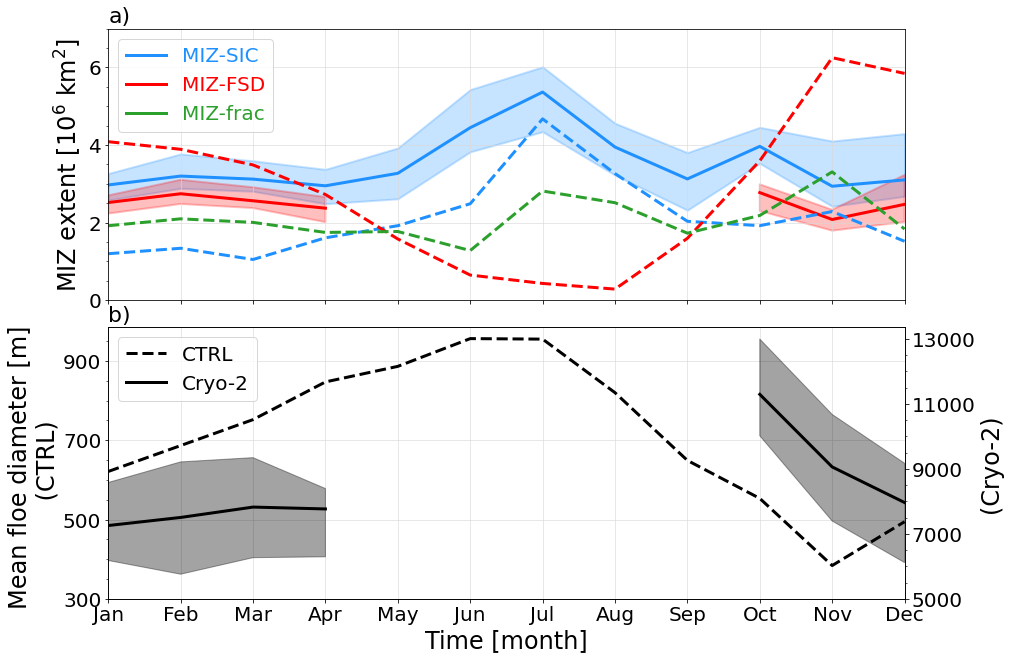

In [40]:
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=[14, 9])
gs = GridSpec(2,1,figure=fig, hspace=0.1, wspace=0.06, width_ratios=[1])
fig.subplots_adjust(left=0.11, right=0.9, bottom=0.08, top=0.96) 

# # Plot 
ax1 = fig.add_subplot(gs[0, 0])
plt.sca(ax1)
ax1.set_title('a)', loc='left', fontsize=22)
ax1.fill_between(monthsl, min_cMIZ_C2, max_cMIZ_C2, alpha = 0.25, color = 'dodgerblue', linestyle='solid',linewidth=2)
ax1.fill_between(monthsl, min_dMIZ_C2, max_dMIZ_C2, alpha = 0.25, color = 'red',linestyle='solid',linewidth=2)  
ax1.plot(monthsl, ts_cMIZ_C2 , 'dodgerblue',label='MIZ-SIC', linewidth=3)
ax1.plot(monthsl, ts_dMIZ_C2, color = 'red',label='MIZ-FSD', linewidth=3)

# axes.fill_between(monthsl, min_cMIZ_IC, max_cMIZ_IC, alpha = 0.2, color = 'tab:blue')
# axes.fill_between(monthsl, min_dMIZ_IC, max_dMIZ_IC, alpha = 0.2, color = 'tab:red')
# axes.plot(monthsl, ts_cMIZ_IC , 'tab:blue',label='cMIZ (CIS)', linewidth=2.5)
# axes.plot(monthsl, ts_dMIZ_IC, color = 'tab:red',label='dMIZ (CIS)', linewidth=2.5)
ax1.plot(monthsl, ts_cMIZ_model, color='dodgerblue', linestyle = '--', linewidth=3)
ax1.plot(monthsl, ts_dMIZ_model, color = 'red', linestyle = '--', linewidth=3)
ax1.plot(monthsl, ts_fMIZ_model, color = 'tab:green', linestyle = '--', linewidth=3)
plt.axhline(y=100, color='tab:green', linestyle='-', linewidth=3, label='MIZ-frac')
# axes.plot(monthsl, ts_fMIZ_model, color = 'tab:olive' ,label='fMIZ (IC4M3)',  linestyle = '--', linewidth=3)
# axes.plot(monthsl, ts_wMIZ_model, color = 'tab:green',label='wMIZ (IC4M3)', linestyle = '--',linewidth=3)
# axes.plot(monthsl, ts_MIZ_aice2, 'k',label='cMIZ IC2', linestyle = ':')
# axes.plot(monthsl, ts_MIZ_wave2, 'b',label='wMIZ IC2', linestyle = ':')
# axes.plot(monthsl, ts_MIZ_fsd2, 'r',label='dMIZ IC2', linestyle = ':')
ax1.set_xticks(monthsl[0:len(monthsl)])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
leg=ax1.legend(loc='upper left', prop={'size': 20})
leg.get_texts()[0].set_color('dodgerblue')
leg.get_texts()[1].set_color('red')
leg.get_texts()[2].set_color('tab:green') 
ax1.set_ylabel(r'MIZ extent [10$^6$ km$^2$]', size=24)
ax1.set_xlim([monthsl[0],monthsl[-1]])
ax1.set_ylim([0,7])
ax1.grid(which="major", axis='y', color='#DAD8D7', alpha=0.75, zorder=-1)
ax1.yaxis.set_ticks(ax1.get_yticks()[::2])
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.set_xticklabels([])
ax1.grid(which="major", axis='x', color='#DAD8D7', alpha=0.75, zorder=-1)
# plt.savefig('panarc_ts_dMIZ_cMIZ_CTRL_Cryo2',dpi='figure',format='png',metadata=None, bbbox_inches=None)

ax3 = fig.add_subplot(gs[1, 0])
plt.sca(ax2)
ax3.set_title('b)', loc='left', fontsize=22)
ax2=ax3.twinx()
ax2.fill_between(monthsl, min_fsd_C2, max_fsd_C2, alpha = 0.2, color = 'k')
ax2.fill_between(monthsl, min_fsd_C2, max_fsd_C2, alpha = 0.2, color = 'k')
line2=ax2.plot(monthsl, ts_fsd_C2 , 'k',label='Cryo-2', linewidth=3)
line1=ax3.plot(monthsl, ts_fsd_model,'k', linestyle='--',label='CTRL', linewidth=3)
lines = line1 + line2
labels = [line.get_label() for line in lines]
ax3.legend(lines, labels, loc='upper left', prop={'size': 20})
# axes.fill_between(monthsl, min_cMIZ_IC, max_cMIZ_IC, alpha = 0.2, color = 'tab:blue')
# axes.fill_between(monthsl, min_dMIZ_IC, max_dMIZ_IC, alpha = 0.2, color = 'tab:red')
# axes.plot(monthsl, ts_cMIZ_IC , 'tab:blue',label='cMIZ (CIS)', linewidth=2.5)
# axes.plot(monthsl, ts_dMIZ_IC, color = 'tab:red',label='dMIZ (CIS)', linewidth=2.5)
# axes[0].plot(monthsl, ts_cMIZ_model, color='dodgerblue',label='SIC-MIZ (CTRL)', linestyle = '--', linewidth=3)
# axes[0].plot(monthsl, ts_dMIZ_model, color = 'red',label='FSD-MIZ (CTRL)', linestyle = '--', linewidth=3)
# axes.plot(monthsl, ts_fMIZ_model, color = 'tab:olive' ,label='fMIZ (IC4M3)',  linestyle = '--', linewidth=3)
# axes.plot(monthsl, ts_wMIZ_model, color = 'tab:green',label='wMIZ (IC4M3)', linestyle = '--',linewidth=3)
# axes.plot(monthsl, ts_MIZ_aice2, 'k',label='cMIZ IC2', linestyle = ':')
# axes.plot(monthsl, ts_MIZ_wave2, 'b',label='wMIZ IC2', linestyle = ':')
# axes.plot(monthsl, ts_MIZ_fsd2, 'r',label='dMIZ IC2', linestyle = ':')
ax3.set_xticks(monthsl[0:len(monthsl)])
plt.sca(ax3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.sca(ax2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# axes[1].legend(loc='upper left', prop={'size': 14})
# ax2.legend(loc='upper right', prop={'size': 14})
ax3.set_ylabel("Mean floe diameter [m] \n (CTRL)", size=24)
ax2.set_ylabel("(Cryo-2)", size=24)
ax3.set_xlim([monthsl[0],monthsl[-1]])
ax3.grid(which="major", axis='y', color='#DAD8D7', alpha=0.75, zorder=-1)
ax3.yaxis.set_ticks(ax3.get_yticks()[::2])
ax3.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_ticks(ax2.get_yticks()[::2])
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax3.set_xlabel(r'Time [month]', size=24)

ax3.grid(which="major", axis='x', color='#DAD8D7', alpha=0.75, zorder=-1)
# ax2.grid(which="major", axis='y', color='#DAD8D7', alpha=0.75, zorder=-1, linestyle='solid')
plt.savefig('panarc_ts_extent_dMIZ_cMIZ_CTRL_Cryo2.png',dpi='figure',format='png',metadata=None, bbbox_inches=None)

(0.0, 11.0)

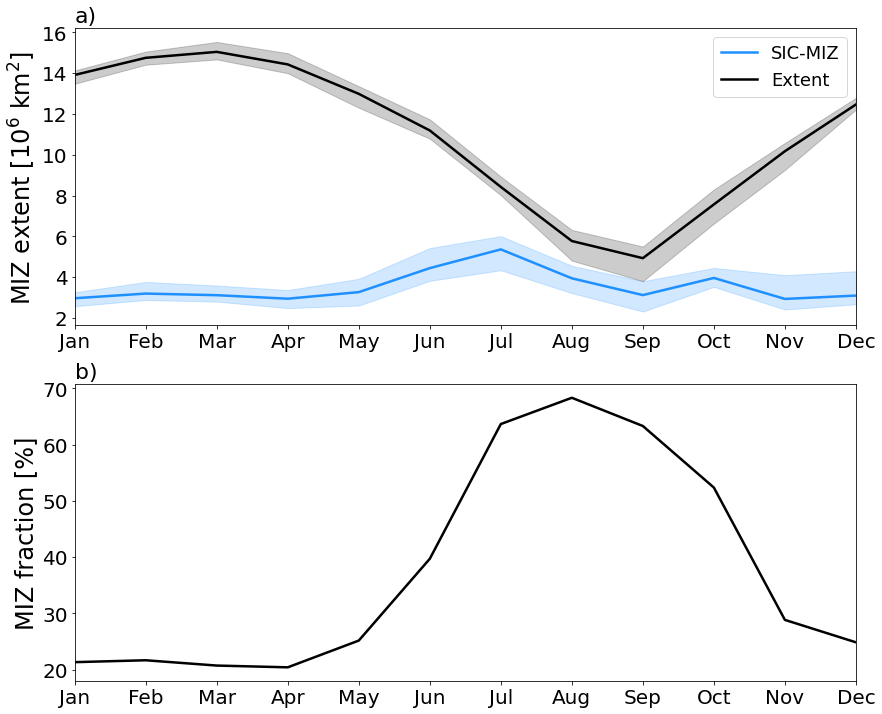

In [35]:
fig, axes = plt.subplots(2,1,figsize=[14,12])
# # Plot 
plt.sca(axes[0])
axes[0].set_title('a)', loc='left', fontsize=22)
axes[0].fill_between(monthsl, min_cMIZ_C2, max_cMIZ_C2, alpha = 0.2, color = 'dodgerblue')
axes[0].fill_between(monthsl, min_extent, max_extent, alpha = 0.2, color = 'k')  
axes[0].plot(monthsl, ts_cMIZ_C2 , 'dodgerblue',label='SIC-MIZ', linewidth=2.5)
axes[0].plot(monthsl, ts_extent , 'k',label='Extent', linewidth=2.5)
# axes[0].plot(monthsl, ts_dMIZ_C2, color = 'red',label='FSD-MIZ', linewidth=2.5)
# axes[0].plot(monthsl, ts_dMIZ_C2, color = 'red',label='FSD-MIZ', linewidth=2.5)

# axes.fill_between(monthsl, min_cMIZ_IC, max_cMIZ_IC, alpha = 0.2, color = 'tab:blue')
# axes.fill_between(monthsl, min_dMIZ_IC, max_dMIZ_IC, alpha = 0.2, color = 'tab:red')
# axes.plot(monthsl, ts_cMIZ_IC , 'tab:blue',label='cMIZ (CIS)', linewidth=2.5)
# axes.plot(monthsl, ts_dMIZ_IC, color = 'tab:red',label='dMIZ (CIS)', linewidth=2.5)
# axes[0].plot(monthsl, ts_cMIZ_model, color='dodgerblue', linestyle = '--', linewidth=3)
# axes[0].plot(monthsl, ts_dMIZ_model, color = 'red', linestyle = '--', linewidth=3)
# axes[0].plot(monthsl, ts_fMIZ_model, color = 'tab:green', linestyle = '--', linewidth=3)
# plt.axhline(y=100, color='tab:green', linestyle='-', linewidth=4, label='frac-MIZ')
# axes.plot(monthsl, ts_fMIZ_model, color = 'tab:olive' ,label='fMIZ (IC4M3)',  linestyle = '--', linewidth=3)
# axes.plot(monthsl, ts_wMIZ_model, color = 'tab:green',label='wMIZ (IC4M3)', linestyle = '--',linewidth=3)
# axes.plot(monthsl, ts_MIZ_aice2, 'k',label='cMIZ IC2', linestyle = ':')
# axes.plot(monthsl, ts_MIZ_wave2, 'b',label='wMIZ IC2', linestyle = ':')
# axes.plot(monthsl, ts_MIZ_fsd2, 'r',label='dMIZ IC2', linestyle = ':')
axes[0].set_xticks(monthsl[0:len(monthsl)])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
leg=axes[0].legend(loc='upper right', prop={'size': 18})
# leg.get_texts()[0].set_color('dodgerblue')
# leg.get_texts()[1].set_color('red')
# leg.get_texts()[2].set_color('tab:green') 
axes[0].set_ylabel(r'MIZ extent [10$^6$ km$^2$]', size=24)
axes[0].set_xlim([monthsl[0],monthsl[-1]])


plt.sca(axes[1])
axes[1].set_title('b)', loc='left', fontsize=22)
axes[1].plot(monthsl, (np.array(ts_cMIZ_C2)/np.array(ts_extent))*100 , 'k',label='Extent', linewidth=2.5)
# axes[0].plot(monthsl, ts_dMIZ_C2, color = 'red',label='FSD-MIZ', linewidth=2.5)
# axes[0].plot(monthsl, ts_dMIZ_C2, color = 'red',label='FSD-MIZ', linewidth=2.5)

# axes.fill_between(monthsl, min_cMIZ_IC, max_cMIZ_IC, alpha = 0.2, color = 'tab:blue')
# axes.fill_between(monthsl, min_dMIZ_IC, max_dMIZ_IC, alpha = 0.2, color = 'tab:red')
# axes.plot(monthsl, ts_cMIZ_IC , 'tab:blue',label='cMIZ (CIS)', linewidth=2.5)
# axes.plot(monthsl, ts_dMIZ_IC, color = 'tab:red',label='dMIZ (CIS)', linewidth=2.5)
# axes[0].plot(monthsl, ts_cMIZ_model, color='dodgerblue', linestyle = '--', linewidth=3)
# axes[0].plot(monthsl, ts_dMIZ_model, color = 'red', linestyle = '--', linewidth=3)
# axes[0].plot(monthsl, ts_fMIZ_model, color = 'tab:green', linestyle = '--', linewidth=3)
# plt.axhline(y=100, color='tab:green', linestyle='-', linewidth=4, label='frac-MIZ')
# axes.plot(monthsl, ts_fMIZ_model, color = 'tab:olive' ,label='fMIZ (IC4M3)',  linestyle = '--', linewidth=3)
# axes.plot(monthsl, ts_wMIZ_model, color = 'tab:green',label='wMIZ (IC4M3)', linestyle = '--',linewidth=3)
# axes.plot(monthsl, ts_MIZ_aice2, 'k',label='cMIZ IC2', linestyle = ':')
# axes.plot(monthsl, ts_MIZ_wave2, 'b',label='wMIZ IC2', linestyle = ':')
# axes.plot(monthsl, ts_MIZ_fsd2, 'r',label='dMIZ IC2', linestyle = ':')
axes[1].set_xticks(monthsl[0:len(monthsl)])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# leg.get_texts()[0].set_color('dodgerblue')
# leg.get_texts()[1].set_color('red')
# leg.get_texts()[2].set_color('tab:green') 
axes[1].set_ylabel(r'MIZ fraction [%]', size=24)
axes[1].set_xlim([monthsl[0],monthsl[-1]])
# axes[0].set_ylim([0,7])
# axes[0].set_xticks([])